# Training & Validation

## Initialization

In [107]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import math

def running_average_smoothing(y, n_samples=10):
    y_smooth = []
    for i in range(0, y.shape[0]):
        avg = 0
        if i < (n_samples-1):
            avg = np.average(y[0:i+1])
        else:
            avg = np.average(y[i-(n_samples-1):i+1])
            if math.isnan(avg):
                raise ValueError(f"index {i}, values {y[i-(n_samples-1):i+1]}")
        y_smooth.append(avg)
    return y_smooth

learning_rates = ["lr5e-5", "lr3e-5", "lr2e-5", "lr1e-5", "lr2e-4"]
epsilons = ["eps1e-8", "eps1e-6"]
training_step = "training_step"
validation_step = "validation_step"

## Fine Tuning

In [4]:
log_dir = os.path.join("logs")
ft_train_f1_score_iii_log_path = os.path.join(log_dir, "ft_train_f1_score_iii.csv")
ft_train_f1_score_EEE_log_path = os.path.join(log_dir, "ft_train_f1_score_EEE.csv")
ft_val_f1_score_iii_log_path = os.path.join(log_dir, "ft_val_f1_score_iii.csv")
ft_val_f1_score_EEE_log_path = os.path.join(log_dir, "ft_val_f1_score_EEE.csv")


ft_train_f1_score_iii_df = pd.read_csv(ft_train_f1_score_iii_log_path)
ft_train_f1_score_EEE_df = pd.read_csv(ft_train_f1_score_EEE_log_path)
ft_val_f1_score_iii_df = pd.read_csv(ft_val_f1_score_iii_log_path)
ft_val_f1_score_EEE_df = pd.read_csv(ft_val_f1_score_EEE_log_path)

### Raw Viz

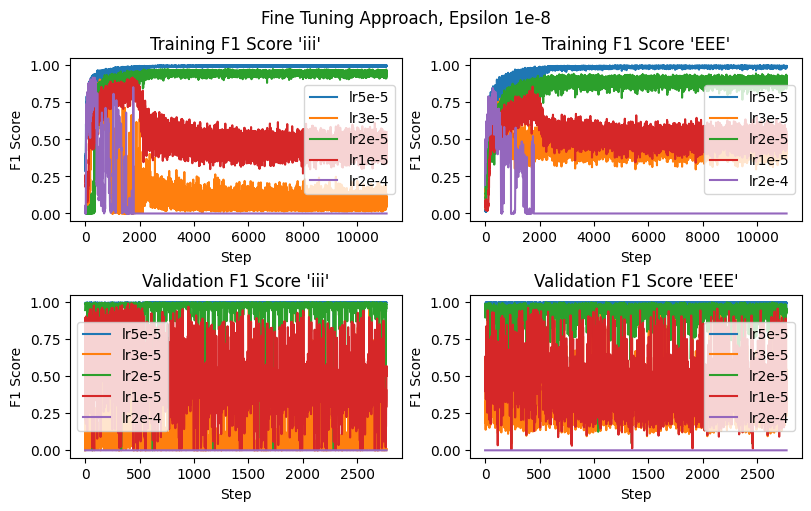

In [12]:
suptitle = "Fine Tuning Approach, Epsilon 1e-8"

figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))

# ft train iii
for lr in learning_rates:
    axes[0][0].plot(
        ft_train_f1_score_iii_df[training_step].values,
        ft_train_f1_score_iii_df[lr].values,
        label=lr
    )

axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'iii'")
axes[0][0].legend()

# ft train EEE
for lr in learning_rates:
    axes[0][1].plot(
        ft_train_f1_score_EEE_df[training_step].values,
        ft_train_f1_score_EEE_df[lr].values,
        label=lr
    )

axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'EEE'")
axes[0][1].legend()

# ft val iii
for lr in learning_rates:
    axes[1][0].plot(
        ft_val_f1_score_iii_df[validation_step].values,
        ft_val_f1_score_iii_df[lr].values,
        label=lr
    )

axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'iii'")
axes[1][0].legend()

# ft val EEE
for lr in learning_rates:
    axes[1][1].plot(
        ft_val_f1_score_EEE_df[validation_step].values,
        ft_val_f1_score_EEE_df[lr].values,
        label=lr
    )

axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'EEE'")
axes[1][1].legend()

plt.suptitle(suptitle)
plt.show()

### Smoothed Viz

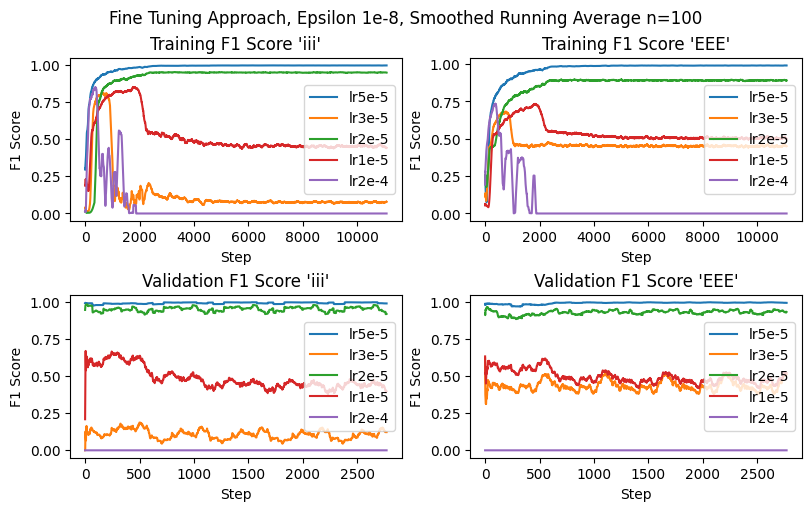

In [48]:
training_step = "training_step"
validation_step = "validation_step"
suptitle = "Fine Tuning Approach, Epsilon 1e-8, Smoothed Running Average n=100"

figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))

# ft train iii
for lr in learning_rates:
    axes[0][0].plot(
        ft_train_f1_score_iii_df[training_step].values,
        running_average_smoothing(
            ft_train_f1_score_iii_df[lr].values,
            100
        ),
        label=lr
    )

axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'iii'")
axes[0][0].legend()

# ft train EEE
for lr in learning_rates:
    axes[0][1].plot(
        ft_train_f1_score_EEE_df[training_step].values,
        running_average_smoothing(
            ft_train_f1_score_EEE_df[lr].values,
            100
        ),
        label=lr
    )

axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'EEE'")
axes[0][1].legend()

# ft val iii
for lr in learning_rates:
    axes[1][0].plot(
        ft_val_f1_score_iii_df[validation_step].values,
        running_average_smoothing(
            ft_val_f1_score_iii_df[lr].values,
            100
        ),
        label=lr
    )

axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'iii'")
axes[1][0].legend()

# ft val EEE
for lr in learning_rates:
    axes[1][1].plot(
        ft_val_f1_score_EEE_df[validation_step].values,
        running_average_smoothing(
            ft_val_f1_score_EEE_df[lr].values,
            100
        ),
        label=lr
    )

axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'EEE'")
axes[1][1].legend()

plt.suptitle(suptitle)
plt.show()

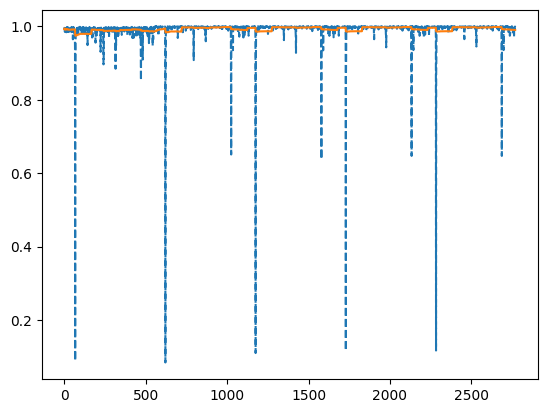

In [82]:
# smoothing
import numpy as np
from scipy.interpolate import interp1d

x = np.asarray(ft_val_f1_score_iii_df[validation_step].values)
y = np.asarray(ft_val_f1_score_iii_df["lr5e-5"].values)
# n_sample = 100
# for i in range(0, y.shape[0]):
#     avg = 0
#     if i < (n_sample-1):
#         avg = np.average(y[0:i+1])
#     else:
#         avg = np.average(y[i-(n_sample-1):i+1])
#     y_smooth.append(avg)

y_smooth = running_average_smoothing(y, 100)
plt.plot(x, y, '--', x, y_smooth, '-')
plt.show()


## Feature Based

In [13]:
learning_rates = ["lr5e-5", "lr3e-5", "lr2e-5", "lr1e-5", "lr2e-4"]

fb_train_f1_score_iii_log_path = os.path.join(log_dir, "fb_train_f1_score_iii.csv")
fb_train_f1_score_EEE_log_path = os.path.join(log_dir, "fb_train_f1_score_EEE.csv")
fb_val_f1_score_iii_log_path = os.path.join(log_dir, "fb_val_f1_score_iii.csv")
fb_val_f1_score_EEE_log_path = os.path.join(log_dir, "fb_val_f1_score_EEE.csv")

fb_train_f1_score_iii_df = pd.read_csv(fb_train_f1_score_iii_log_path)
fb_train_f1_score_EEE_df = pd.read_csv(fb_train_f1_score_EEE_log_path)
fb_val_f1_score_iii_df = pd.read_csv(fb_val_f1_score_iii_log_path)
fb_val_f1_score_EEE_df = pd.read_csv(fb_val_f1_score_EEE_log_path)

### Raw Viz

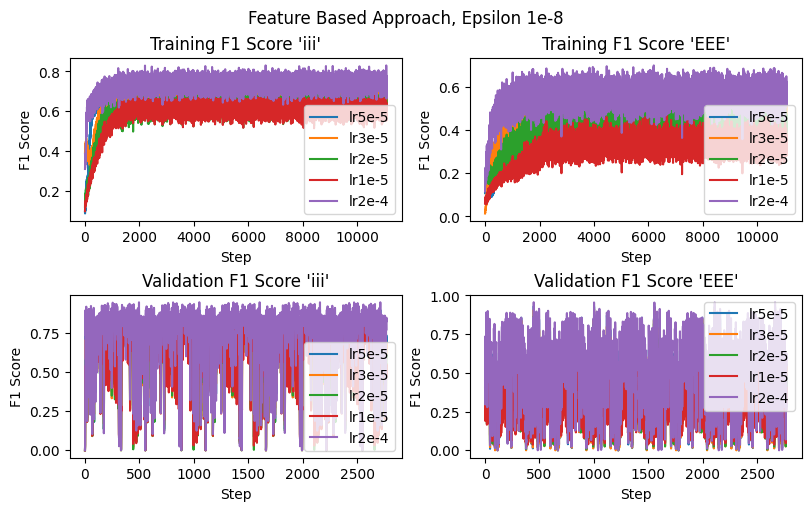

In [14]:
training_step = "training_step"
validation_step = "validation_step"
suptitle = "Feature Based Approach, Epsilon 1e-8"

figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))

# ft train iii
for lr in learning_rates:
    axes[0][0].plot(
        fb_train_f1_score_iii_df[training_step].values,
        fb_train_f1_score_iii_df[lr].values,
        label=lr
    )

axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'iii'")
axes[0][0].legend()

# ft train EEE
for lr in learning_rates:
    axes[0][1].plot(
        fb_train_f1_score_EEE_df[training_step].values,
        fb_train_f1_score_EEE_df[lr].values,
        label=lr
    )

axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'EEE'")
axes[0][1].legend()

# ft val iii
for lr in learning_rates:
    axes[1][0].plot(
        fb_val_f1_score_iii_df[validation_step].values,
        fb_val_f1_score_iii_df[lr].values,
        label=lr
    )

axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'iii'")
axes[1][0].legend()

# ft val EEE
for lr in learning_rates:
    axes[1][1].plot(
        fb_val_f1_score_EEE_df[validation_step].values,
        fb_val_f1_score_EEE_df[lr].values,
        label=lr
    )

axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'EEE'")
axes[1][1].legend()

plt.suptitle(suptitle)
plt.show()


### Smoothed Viz

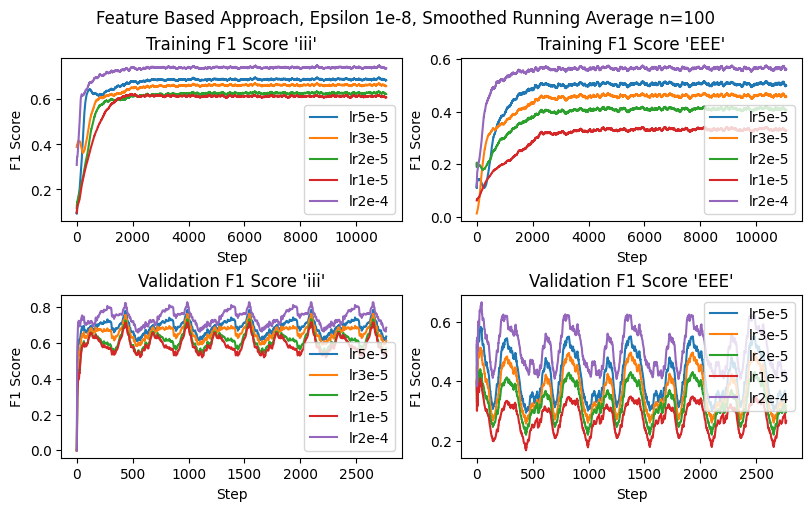

In [50]:
training_step = "training_step"
validation_step = "validation_step"
suptitle = "Feature Based Approach, Epsilon 1e-8, Smoothed Running Average n=100"

figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))

# ft train iii
for lr in learning_rates:
    axes[0][0].plot(
        fb_train_f1_score_iii_df[training_step].values,
        running_average_smoothing(
            fb_train_f1_score_iii_df[lr].values,
            100
        ),
        label=lr
    )

axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'iii'")
axes[0][0].legend()

# ft train EEE
for lr in learning_rates:
    axes[0][1].plot(
        fb_train_f1_score_EEE_df[training_step].values,
        running_average_smoothing(
            fb_train_f1_score_EEE_df[lr].values,
            100
        ),
        label=lr
    )

axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'EEE'")
axes[0][1].legend()

# ft val iii
for lr in learning_rates:
    axes[1][0].plot(
        fb_val_f1_score_iii_df[validation_step].values,
        running_average_smoothing(
            fb_val_f1_score_iii_df[lr].values,
            100
        ),
        label=lr
    )

axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'iii'")
axes[1][0].legend()

# ft val EEE
for lr in learning_rates:
    axes[1][1].plot(
        fb_val_f1_score_EEE_df[validation_step].values,
        running_average_smoothing(
            fb_val_f1_score_EEE_df[lr].values,
            100
        ),
        label=lr
    )

axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'EEE'")
axes[1][1].legend()

plt.suptitle(suptitle)
plt.show()

## Validation Fine Tuning v. Feature Based

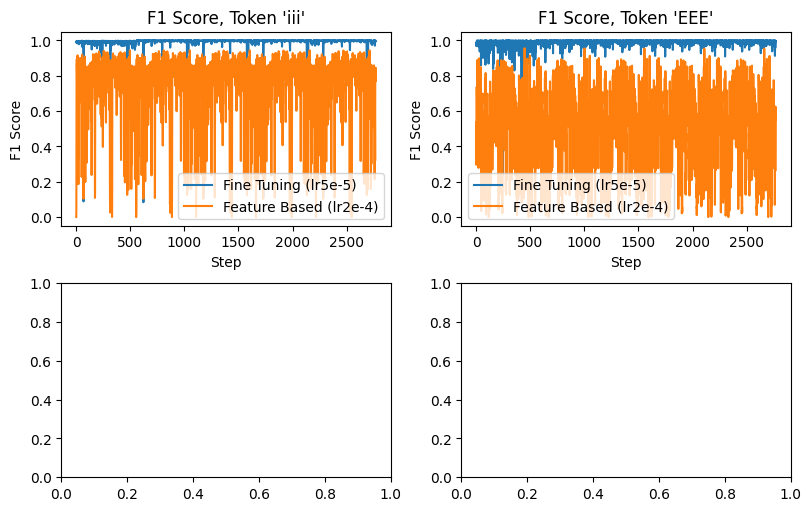

In [125]:
import pandas as pd
import os
import matplotlib.pyplot as plt

log_dir = os.path.join("logs")
fb_f1_score_EEE = pd.read_csv(
    os.path.join(log_dir, "fb_val_f1_score_EEE.csv")
)
fb_f1_score_iii = pd.read_csv(
    os.path.join(log_dir, "fb_val_f1_score_iii.csv")
)
ft_f1_score_EEE = pd.read_csv(
    os.path.join(log_dir, "ft_val_f1_score_EEE.csv")
)
ft_f1_score_iii = pd.read_csv(
    os.path.join(log_dir, "ft_val_f1_score_iii.csv")
)

selected_lr = ["lr2e-4", "lr5e-5"]
suptitle = "Fine Tuning v. Feature Based"
figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))

# iii
axes[0][0].plot(
    ft_f1_score_iii["validation_step"].values,
    ft_f1_score_iii["lr5e-5"].values,
    label="Fine Tuning (lr5e-5)"
)
axes[0][0].plot(
    fb_f1_score_iii["validation_step"].values,
    fb_f1_score_iii["lr2e-4"].values,
    label="Feature Based (lr2e-4)"
)
axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="F1 Score, Token 'iii'")
axes[0][0].legend()

# EEE
axes[0][1].plot(
    ft_f1_score_EEE["validation_step"].values,
    ft_f1_score_EEE["lr5e-5"].values,
    label="Fine Tuning (lr5e-5)"
)
axes[0][1].plot(
    fb_f1_score_EEE["validation_step"].values,
    fb_f1_score_EEE["lr2e-4"].values,
    label="Feature Based (lr2e-4)"
)
axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="F1 Score, Token 'EEE'")
axes[0][1].legend()

# iii smoothed
axes[0][0].plot(
    ft_f1_score_iii["validation_step"].values,
    running_average_smoothing(
        ft_f1_score_iii["lr5e-5"].values,
        100
    ),
    label="Fine Tuning (lr5e-5)"
)
axes[0][0].plot(
    fb_f1_score_iii["validation_step"].values,
    running_average_smoothing(
        fb_f1_score_iii["lr2e-4"].values,
        100
    ),
    label="Feature Based (lr2e-4)"
)
axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="F1 Score, Token 'iii', Smoothed Running Average n=100")
axes[0][0].legend()

# EEE smoothed
axes[0][1].plot(
    ft_f1_score_EEE["validation_step"].values,
    running_average_smoothing(
        ft_f1_score_EEE["lr5e-5"].values,
        100
    ),
    label="Fine Tuning (lr5e-5)"
)
axes[0][1].plot(
    fb_f1_score_EEE["validation_step"].values,
    running_average_smoothing(
        fb_f1_score_EEE["lr2e-4"].values,
        100
    ),
    label="Feature Based (lr2e-4)"
)
axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="F1 Score, Token 'EEE', Smoothed Running Average n=100")
axes[0][1].legend()

plt.show()

## Epoch

### Feature Based

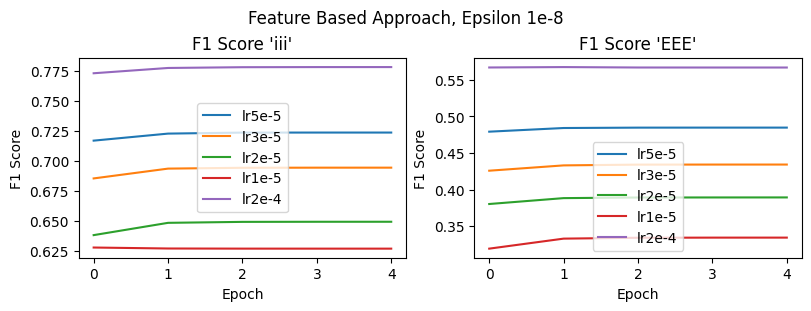

In [57]:
import pandas as pd
import os
import matplotlib.pyplot as plt

log_dir = os.path.join("logs")
fb_f1_score_EEE_log_path = os.path.join(log_dir, "fb_f1_score_EEE.csv")
fb_f1_score_iii_log_path = os.path.join(log_dir, "fb_f1_score_iii.csv")
ft_f1_score_EEE_log_path = os.path.join(log_dir, "ft_f1_score_EEE.csv")
ft_f1_score_iii_log_path = os.path.join(log_dir, "ft_f1_score_iii.csv")

fb_f1_score_EEE_df = pd.read_csv(fb_f1_score_EEE_log_path)
fb_f1_score_iii_df = pd.read_csv(fb_f1_score_iii_log_path)
ft_f1_score_EEE_df = pd.read_csv(ft_f1_score_EEE_log_path)
ft_f1_score_iii_df = pd.read_csv(ft_f1_score_iii_log_path)


figs, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8, 3))
xs = [i for i in range(5)]

# feature based.
suptitle = "Feature Based Approach, Epsilon 1e-8"
for lr in learning_rates:
    axes[0].plot(
        xs,
        fb_f1_score_iii_df[lr].values,
        label=lr
    )
axes[0].set(xlabel="Epoch", ylabel="F1 Score", title="F1 Score 'iii'")
axes[0].legend()

for lr in learning_rates:
    axes[1].plot(
        xs,
        fb_f1_score_EEE_df[lr].values,
        label=lr
    )
axes[1].set(xlabel="Epoch", ylabel="F1 Score", title="F1 Score 'EEE'")
axes[1].legend()

plt.suptitle(suptitle)
plt.show()



### Fine Tuning

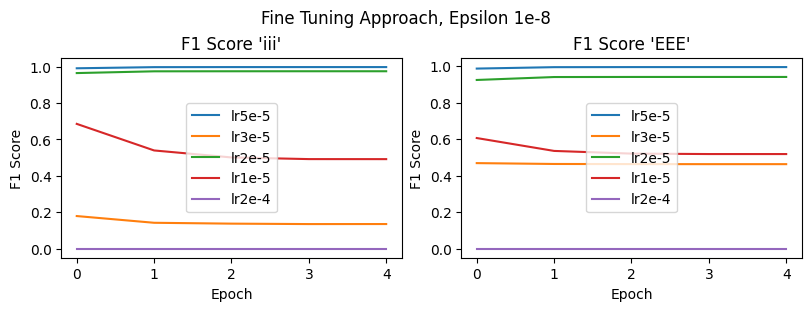

In [58]:
figs, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8, 3))
xs = [i for i in range(5)]

# feature based.
suptitle = "Fine Tuning Approach, Epsilon 1e-8"
for lr in learning_rates:
    axes[0].plot(
        xs,
        ft_f1_score_iii_df[lr].values,
        label=lr
    )
axes[0].set(xlabel="Epoch", ylabel="F1 Score", title="F1 Score 'iii'")
axes[0].legend()

for lr in learning_rates:
    axes[1].plot(
        xs,
        ft_f1_score_EEE_df[lr].values,
        label=lr
    )
axes[1].set(xlabel="Epoch", ylabel="F1 Score", title="F1 Score 'EEE'")
axes[1].legend()

plt.suptitle(suptitle)
plt.show()


## Epsilon Effect on Performance

### Raw Viz

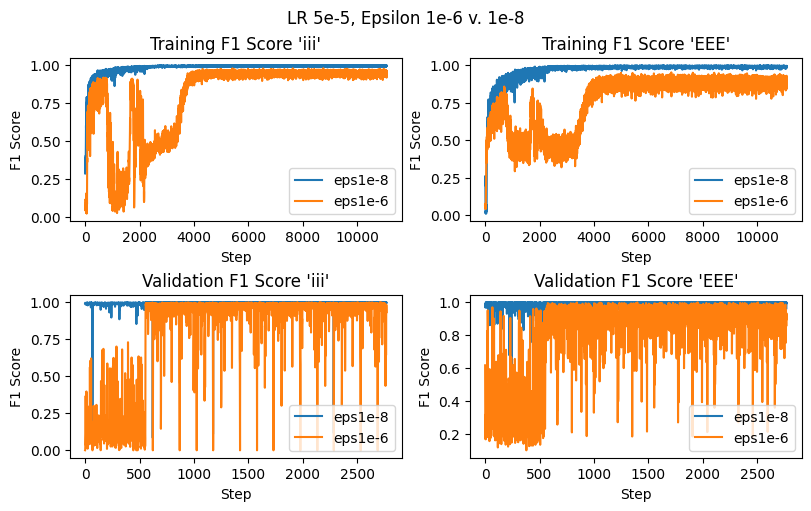

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import os

log_dir = os.path.join("logs")

ft_f1_score_eps_EEE = pd.read_csv(os.path.join(log_dir, "ft_f1_score_eps1e-6v1e-8_EEE.csv"))
ft_f1_score_eps_iii = pd.read_csv(os.path.join(log_dir, "ft_f1_score_eps1e-6v1e-8_iii.csv"))
ft_train_f1_score_eps_EEE = pd.read_csv(os.path.join(log_dir, "ft_train_f1_score_eps1e-6v1e-8_EEE.csv"))
ft_train_f1_score_eps_iii = pd.read_csv(os.path.join(log_dir, "ft_train_f1_score_eps1e-6v1e-8_iii.csv"))
ft_val_f1_score_eps_EEE = pd.read_csv(os.path.join(log_dir, "ft_val_f1_score_eps1e-6v1e-8_EEE.csv"))
ft_val_f1_score_eps_iii = pd.read_csv(os.path.join(log_dir, "ft_val_f1_score_eps1e-6v1e-8_iii.csv"))

figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))

suptitle="LR 5e-5, Epsilon 1e-6 v. 1e-8"

# train
for eps in epsilons:
    axes[0][0].plot(
        ft_train_f1_score_eps_iii[training_step].values,
        ft_train_f1_score_eps_iii[eps].values,
        label=eps
    )
axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'iii'")   
axes[0][0].legend()

for eps in epsilons:
    axes[0][1].plot(
        ft_train_f1_score_eps_EEE[training_step].values,
        ft_train_f1_score_eps_EEE[eps].values,
        label=eps
    )
axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'EEE'")   
axes[0][1].legend()

# validation
for eps in epsilons:
    axes[1][0].plot(
        ft_val_f1_score_eps_iii[validation_step].values,
        ft_val_f1_score_eps_iii[eps].values,
        label=eps
    )
axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'iii'")   
axes[1][0].legend()

for eps in epsilons:
    axes[1][1].plot(
        ft_val_f1_score_eps_EEE[validation_step].values,
        ft_val_f1_score_eps_EEE[eps].values,
        label=eps
    )
axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'EEE'")   
axes[1][1].legend()

plt.suptitle(suptitle)
plt.show()

### Smoothed Viz

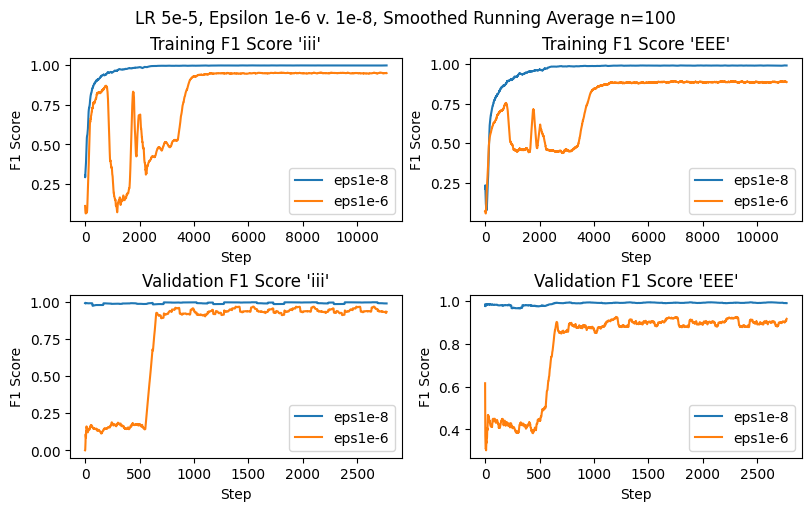

In [71]:
figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))

suptitle="LR 5e-5, Epsilon 1e-6 v. 1e-8, Smoothed Running Average n=100"

# train
for eps in epsilons:
    axes[0][0].plot(
        ft_train_f1_score_eps_iii[training_step].values,
        running_average_smoothing(
            ft_train_f1_score_eps_iii[eps].values,
            100
        ),
        label=eps
    )
axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'iii'")   
axes[0][0].legend()

for eps in epsilons:
    axes[0][1].plot(
        ft_train_f1_score_eps_EEE[training_step].values,
        running_average_smoothing(
            ft_train_f1_score_eps_EEE[eps].values,
            100
        ),
        label=eps
    )
axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Training F1 Score 'EEE'")   
axes[0][1].legend()

# validation
for eps in epsilons:
    axes[1][0].plot(
        ft_val_f1_score_eps_iii[validation_step].values,
        running_average_smoothing(
            ft_val_f1_score_eps_iii[eps].values,
            100
        ),
        label=eps
    )
axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'iii'")   
axes[1][0].legend()

for eps in epsilons:
    axes[1][1].plot(
        ft_val_f1_score_eps_EEE[validation_step].values,
        running_average_smoothing(
            ft_val_f1_score_eps_EEE[eps].values,
            100
        ),
        label=eps
    )
axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Validation F1 Score 'EEE'")   
axes[1][1].legend()

plt.suptitle(suptitle)
plt.show()

## Base v. Lin1

In [115]:
import os
import pandas as pd
import matplotlib.pyplot as plt

log_dir = os.path.join(log_dir)
ft_f1_score_base_versus_lin1 = pd.read_csv(os.path.join(log_dir, "ft_f1_score_base_versus_lin1_intrapolate.csv"))

archs = ["base", "lin1"]
labels = ["iii", "iiE", "iEi", "Eii", "iEE", "EEi", "EiE", "EEE"]

base_iii = f"{archs[0]}-{labels[0]}"
base_iiE = f"{archs[0]}-{labels[1]}"
base_iEi = f"{archs[0]}-{labels[2]}"
base_Eii = f"{archs[0]}-{labels[3]}"
base_iEE = f"{archs[0]}-{labels[4]}"
base_EEi = f"{archs[0]}-{labels[5]}"
base_EiE = f"{archs[0]}-{labels[6]}"
base_EEE = f"{archs[0]}-{labels[7]}"

lin1_iii = f"{archs[1]}-{labels[0]}"
lin1_iiE = f"{archs[1]}-{labels[1]}"
lin1_iEi = f"{archs[1]}-{labels[2]}"
lin1_Eii = f"{archs[1]}-{labels[3]}"
lin1_iEE = f"{archs[1]}-{labels[4]}"
lin1_EEi = f"{archs[1]}-{labels[5]}"
lin1_EiE = f"{archs[1]}-{labels[6]}"
lin1_EEE = f"{archs[1]}-{labels[7]}"

validation_step = "validation_step"


### Raw Viz

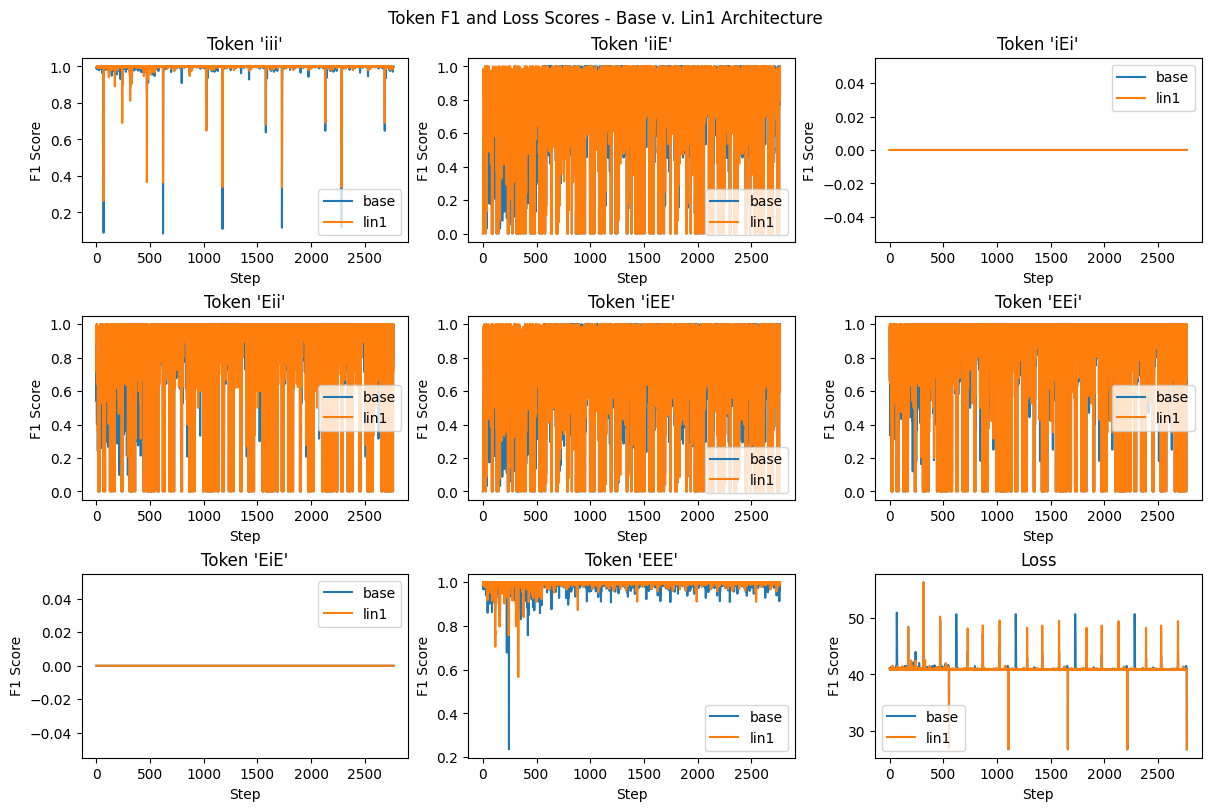

In [116]:
suptitle = "Token F1 and Loss Scores - Base v. Lin1 Architecture"
figs, axes = plt.subplots(nrows=3, ncols=3, constrained_layout=True, figsize=(12, 8))

# iii
for a in archs:
    axes[0][0].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-iii"].values,
        label=a
    )
axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Token 'iii'")
axes[0][0].legend()

# iiE
for a in archs:
    axes[0][1].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-iiE"].values,
        label=a
    )
axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Token 'iiE'")
axes[0][1].legend()

# iEi
for a in archs:
    axes[0][2].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-iEi"].values,
        label=a
    )
axes[0][2].set(xlabel="Step", ylabel="F1 Score", title="Token 'iEi'")
axes[0][2].legend()

# Eii
for a in archs:
    axes[1][0].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-Eii"].values,
        label=a
    )
axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Token 'Eii'")
axes[1][0].legend()

# iEE
for a in archs:
    axes[1][1].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-iEE"].values,
        label=a
    )
axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Token 'iEE'")
axes[1][1].legend()

# EEi
for a in archs:
    axes[1][2].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-EEi"].values,
        label=a
    )
axes[1][2].set(xlabel="Step", ylabel="F1 Score", title="Token 'EEi'")
axes[1][2].legend()

# EiE 
for a in archs:
    axes[2][0].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-EiE"].values,
        label=a
    )
axes[2][0].set(xlabel="Step", ylabel="F1 Score", title="Token 'EiE'")
axes[2][0].legend()

# EEE
for a in archs:
    axes[2][1].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-EEE"].values,
        label=a
    )
axes[2][1].set(xlabel="Step", ylabel="F1 Score", title="Token 'EEE'")
axes[2][1].legend()

# loss
for a in archs:
    axes[2][2].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-loss"].values,
        label=a
    )
axes[2][2].set(xlabel="Step", ylabel="F1 Score", title="Loss")
axes[2][2].legend()

# showtime!
plt.suptitle(suptitle)
plt.show()


### Smoothed Viz

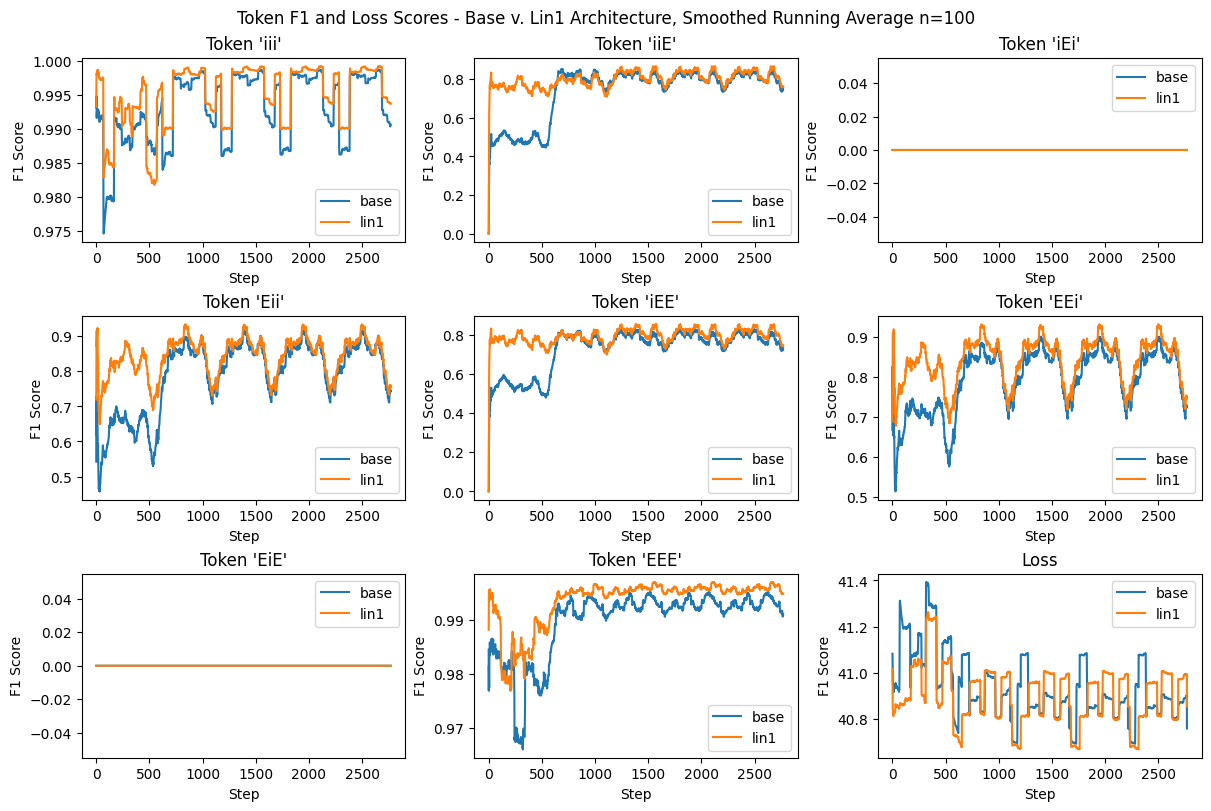

In [117]:
suptitle = "Token F1 and Loss Scores - Base v. Lin1 Architecture, Smoothed Running Average n=100"
figs, axes = plt.subplots(nrows=3, ncols=3, constrained_layout=True, figsize=(12, 8))

# iii
for a in archs:
    axes[0][0].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-iii"].values,
            100
        ),
        label=a
    )
axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Token 'iii'")
axes[0][0].legend()

# iiE
for a in archs:
    axes[0][1].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-iiE"].values,
            100
        ),
        label=a
    )
axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Token 'iiE'")
axes[0][1].legend()

# iEi
for a in archs:
    axes[0][2].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-iEi"].values,
            100
        ),
        label=a
    )
axes[0][2].set(xlabel="Step", ylabel="F1 Score", title="Token 'iEi'")
axes[0][2].legend()

# Eii
for a in archs:
    axes[1][0].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-Eii"].values,
            100
        ),
        label=a
    )
axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Token 'Eii'")
axes[1][0].legend()

# iEE
for a in archs:
    axes[1][1].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-iEE"].values,
            100
        ),
        label=a
    )
axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Token 'iEE'")
axes[1][1].legend()

# EEi
for a in archs:
    axes[1][2].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-EEi"].values,
            100
        ),
        label=a
    )
axes[1][2].set(xlabel="Step", ylabel="F1 Score", title="Token 'EEi'")
axes[1][2].legend()

# EiE 
for a in archs:
    axes[2][0].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-EiE"].values,
            100
        ),
        label=a
    )
axes[2][0].set(xlabel="Step", ylabel="F1 Score", title="Token 'EiE'")
axes[2][0].legend()

# EEE
for a in archs:
    axes[2][1].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-EEE"].values,
            100
        ),
        label=a
    )
axes[2][1].set(xlabel="Step", ylabel="F1 Score", title="Token 'EEE'")
axes[2][1].legend()

# loss
for a in archs:
    axes[2][2].plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-loss"].values,
            100
        ),
        label=a
    )
axes[2][2].set(xlabel="Step", ylabel="F1 Score", title="Loss")
axes[2][2].legend()

# showtime!
plt.suptitle(suptitle)
plt.show()

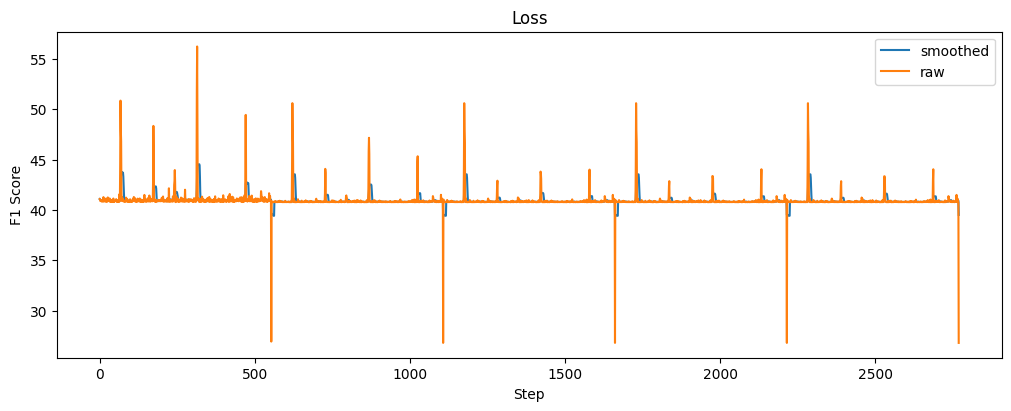

In [118]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 4))

# loss
for a in [archs[0]]:
    ax.plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        running_average_smoothing(
            ft_f1_score_base_versus_lin1[f"{a}-loss"].values,
            10
        ),
        label='smoothed'
    )

ax.plot(
        ft_f1_score_base_versus_lin1[validation_step].values,
        ft_f1_score_base_versus_lin1[f"{a}-loss"].values,
        label='raw'
    )
ax.set(xlabel="Step", ylabel="F1 Score", title="Loss")
ax.legend()

plt.show()